In [29]:
import numpy as np
import SpringRank_tools as sr
import json
import matplotlib.pyplot as plt

In [30]:
class Game:
    def __init__(self, winner, loser, rnd = -1):
        self.winner = winner
        self.loser = loser
        self.round = rnd
        
data = np.loadtxt('./2019Box.csv',
                  dtype={'names': ('date', 'team', 'place', 'opponent', 'score'),
                         'formats': ('U20', 'U20', 'U5', 'U20', 'i4')},
                 delimiter = ',')

with open('2019.json') as f:
    mm_data = json.load(f)

In [31]:
games = []
for i in range(int(len(data) / 2)):
    away = data[2 * i]
    home = data[2 * i + 1]
    if home['score'] > away['score']:
        games.append(Game(home['team'], away['team']))
    else:
        games.append(Game(away['team'], home['team']))
        
mm_games = []

for reg in range(4):
    for rnd in range(4):
        for g_num in range(2**(3 - rnd)):
            if mm_data['regions'][reg][rnd][g_num][0]['score'] > \
            mm_data['regions'][reg][rnd][g_num][1]['score']:
                mm_games.append(Game(mm_data['regions'][reg][rnd][g_num][0]['team'],
                                    mm_data['regions'][reg][rnd][g_num][1]['team'],
                                    mm_data['regions'][reg][rnd][g_num][0]['round_of']))
            else:
                mm_games.append(Game(mm_data['regions'][reg][rnd][g_num][1]['team'],
                                    mm_data['regions'][reg][rnd][g_num][0]['team'],
                                    mm_data['regions'][reg][rnd][g_num][0]['round_of']))
                
for rnd in range(2):
    for g_num in range(2**(1 - rnd)):
        if mm_data['finalfour'][rnd][g_num][0]['score'] > \
        mm_data['finalfour'][rnd][g_num][1]['score']:
            mm_games.append(Game(mm_data['finalfour'][rnd][g_num][0]['team'],
                                mm_data['finalfour'][rnd][g_num][1]['team'],
                                mm_data['finalfour'][rnd][g_num][0]['round_of']))
        else:
            mm_games.append(Game(mm_data['finalfour'][rnd][g_num][1]['team'],
                                mm_data['finalfour'][rnd][g_num][0]['team'],
                                mm_data['finalfour'][rnd][g_num][0]['round_of']))
        
teams = list(set(data['team']))
teams.sort()

team_dict = {}
count = 0
for t in teams:
    team_dict[t] = count
    count += 1

In [32]:
adj_mat = np.zeros((len(teams), len(teams)))

for g in games:
    adj_mat[team_dict[g.winner], team_dict[g.loser]] += 1

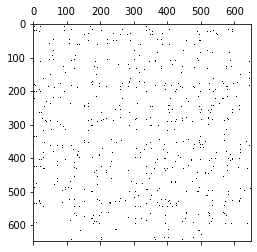

In [33]:
plt.spy(adj_mat)
plt.show()

In [34]:
rank = sr.SpringRank(adj_mat) # Compute spring rank
rank = np.argsort(-rank) # Sorts to give the index of that ranking

In [35]:
print(teams[rank[0]]) # Duke first overall seed
print(teams[rank[1]]) # Virginia second overall seed
print(teams[rank[-1]]) # Cairn lowest overall seed (division 3)

Duke
Virginia
St. Elizabeth


In [36]:
for i in range(10):
    print(teams[rank[i]])

Duke
Virginia
Tennessee
Michigan State
UNC
Kentucky
Kansas
Michigan
Houston
LSU


In [37]:
rank_dict = {}
for i in range(len(teams)):
    rank_dict[teams[rank[i]]] = i

In [38]:
rank_dict['Montana'] # spring rank of a given team

115

In [39]:
print(rank_dict['Michigan State'])
print(rank_dict['Texas Tech'])

3
11


In [42]:
for g in mm_games:
    print(rank_dict[g.winner], rank_dict[g.loser])

0 195
27 32
86 20
24 81
23 55
9 67
31 29
3 149
0 27
24 86
9 23
3 31
0 24
3 9
3 0
12 210
41 36
51 22
10 84
15 42
11 103
39 25
7 115
12 41
10 51
11 15
7 39
12 10
11 7
11 12
1 172
28 40
52 19
64 13
18 59
14 63
30 16
2 123
1 28
52 64
14 18
2 30
1 52
14 2
1 14
4 224
26 38
17 43
6 76
45 21
8 71
33 37
5 122
4 26
17 6
8 45
5 33
17 4
5 8
17 5
11 3
1 17
1 11
